In [3]:
import matplotlib.pyplot as plt
import procthor
from procthor.simulators import SceneGraphSimulator
import object_search
from object_search.planners import PlanningLoop, OptimisticPlanner, LearnedPlanner
from pathlib import Path


def get_args():
    args = lambda key: None  # noqa
    args.save_dir = '/data/test_logs'
    args.current_seed = 1
    args.resolution = 0.05
    args.do_save_video = True
    args.network_file = '/data/object_search/fcnn.pt'
    return args
    
def test_object_search_learned_planner():
    '''Test object search in ProcTHOR environment with OptimisticPlanner'''
    args = get_args()
    thor_interface = procthor.ThorInterface(args)
    known_graph, known_grid, robot_pose, target_obj_info = thor_interface.gen_map_and_poses()
    learned_simulator = SceneGraphSimulator(known_graph,
                                            args,
                                            target_obj_info,
                                            known_grid,
                                            thor_interface)
    learned_robot = object_search.robot.Robot(robot_pose)
    learned_planner = LearnedPlanner(target_obj_info, args)
    learned_planning_loop = PlanningLoop(target_obj_info, learned_simulator, learned_robot, args=args)
    for _, step_data in enumerate(learned_planning_loop):
        learned_planner.update(
            step_data['observed_graph'],
            step_data['observed_grid'],
            step_data['subgoals'],
            step_data['robot_pose'])
        # print(step_data['observed_graph'].idx_map)
        chosen_subgoal = learned_planner.compute_selected_subgoal()
        learned_planning_loop.set_chosen_subgoal(chosen_subgoal)
    learned_cost, learned_trajectory = object_search.utils.compute_cost_and_trajectory(known_grid,
                                                                                       learned_robot.all_poses)
    cost, trajectory = object_search.utils.compute_cost_and_trajectory(known_grid, learned_robot.all_poses)
    plt.figure(figsize=(8, 8))
    known_locations = [known_graph.get_node_name_by_idx(idx) for idx in target_obj_info['container_idxs']]
    plt.suptitle(f"Seed: {args.current_seed} | Target object: {target_obj_info['name']}\n"
                 f"Known locations: {known_locations} ")
    ax = plt.subplot(221)
    plt.title('Whole scene graph')
    procthor.plotting.plot_graph(ax, known_graph.nodes, known_graph.edges)
    ax = plt.subplot(222)
    procthor.plotting.plot_graph_on_grid(ax, known_grid, known_graph)
    plt.text(robot_pose.x, robot_pose.y, '+', color='red', size=6, rotation=45)
    plt.title('Graph over occupancy grid')
    plt.subplot(223)
    top_down_image = learned_simulator.get_top_down_image()
    plt.imshow(top_down_image)
    plt.title('Top-down view of the map')
    plt.axis('off')
    plt.subplot(224)
    ax = plt.subplot(224)
    object_search.plotting.plot_grid_with_robot_trajectory(ax, known_grid, learned_robot.all_poses, trajectory, known_graph)
    plt.title(f"Cost: {cost:0.3f}")
    # print('testing')

Target object: ladle
Known locations: ['countertop']
Counter: 0 | Count since last turnaround: 100
Searching in container: countertop
<Pose x:17.000000, y:55.000000, yaw:0.000000>
(17, 55)
 
TOTAL TIME:  0.0006489753723144531


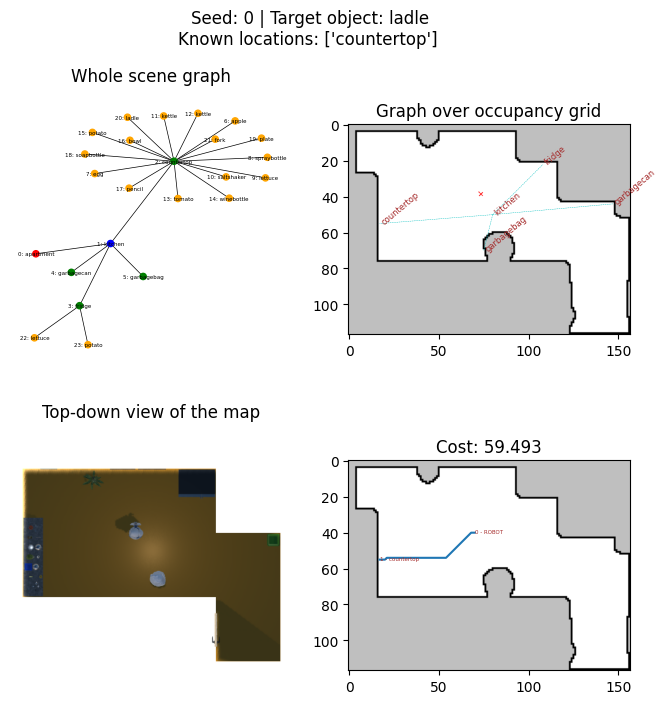

In [4]:
test_object_search_learned_planner()

In [23]:
#!/usr/bin/env python3
import time
import random
import matplotlib.pyplot as plt

import procthor
from procthor.simulators import SceneGraphSimulator
from object_search.robot import Robot
from common import Pose

from object_search.core import Fluent, State, Operator, Effect, transition, get_next_actions
from typing import Tuple, Dict, Set, List, Callable

# ——————————————————————————————————————————————————————————————————————————————
# 1) MRPPDDL‐style helpers
# ——————————————————————————————————————————————————————————————————————————————

def compute_fluents(
    robot_pos: Tuple[int,int],
    graph: Dict[int, dict],
    holding: Set[str],
) -> Set[Fluent]:
    fs: Set[Fluent] = set()
    fs.add(Fluent("free", "robot"))
    for node in graph.values():
        obj_id = node["id"]
        x, y = node["position"]
        manh = abs(robot_pos[0] - x) + abs(robot_pos[1] - y)

        # container nodes (type != object) get at/near
        if node["type"] == [0,0,1,0]:
            if robot_pos == (x, y):
                fs.add(Fluent("at", "robot", obj_id))
            else:
                fs.add(~Fluent("at", "robot", obj_id))
            if manh <= 20:
                fs.add(Fluent("near", "robot", obj_id))
            else:
                fs.add(~Fluent("near", "robot", obj_id))

        if node["type"] == [0, 0, 0, 1]:  # objects
            # Find which location the object is in/near
            for loc_id, loc in locations.items():
                loc_x, loc_y = loc["position"]
                obj_to_loc_dist = abs(x - loc_x) + abs(y - loc_y)
                if obj_to_loc_dist <= 20:  # Object is at/near this location
                    fs.add(Fluent("at", obj_id, loc["id"]))
                else:
                    fs.add(~Fluent("at", obj_id, loc["id"]))

        # holding applies to all nodes
        if obj_id in holding:
            fs.add(Fluent("holding", "robot", obj_id))
        else:
            fs.add(~Fluent("holding", "robot", obj_id))

    return {f for f in fs if not f.negated}


def make_operators(
    graph: Dict[int, dict],
    get_robot_pos: Callable[[], Tuple[int,int]]
) -> List[Operator]:
    """
    Build your operators with the requested parameter names,
    and a move_to whose cost is the Manhattan distance from
    the current robot_pos to ?loc_to.
    """
    # time function closure: reads the live robot_pos and graph
    def move_time_fn(_robot_id: str, loc_to_id: str) -> float:
        # current robot grid‐cell
        rx, ry = get_robot_pos()
        # find the node in your graph
        for node in graph.values():
            if node["id"] == loc_to_id:
                tx, ty = node["position"]
                break
        else:
            raise ValueError(f"Unknown loc_to {loc_to_id}")
        # Manhattan distance (or scale however you like)
        return abs(rx - tx) + abs(ry - ty)

    # —— move_to: only needs free(robot), no from_loc precond
    move_to_op = Operator(
        name="move_to",
        parameters=[("?robot","robot"), ("?loc_to","location")],
        preconditions=[
            Fluent("free", "?robot")
        ],
        effects=[
            # “start walking” flips free → false immediately
            Effect(time=0, resulting_fluents={~Fluent("free","?robot")}),
            # after the computed travel time, robot is free again and at the destination
            Effect(
                time=(move_time_fn, ["?robot","?loc_to"]),
                resulting_fluents={
                    Fluent("free","?robot"),
                    Fluent("at","?robot","?loc_to")
                }
            )
        ]
    )

    # —— search (unchanged names)
    search_op = Operator(
        name="search",
        parameters=[("?robot","robot"),("?loc_to","location")],
        preconditions=[
            Fluent("free","?robot"),
            Fluent("at","?robot","?loc_to"),
            ~Fluent("searched","?loc_to")
        ],
        effects=[
            Effect(time=5, resulting_fluents={Fluent("searched","?loc_to")})
        ]
    )

    # —— pick_up with ?obj
    pick_up_op = Operator(
        name="pick_up",
        parameters=[("?robot","robot"),("?obj","object"),("?loc_to","location")],
        preconditions=[
            Fluent("free","?robot"),
            Fluent("at","?robot","?loc_to"),
            Fluent("near","?robot","?obj"),
            ~Fluent("holding","?robot","?obj")
        ],
        effects=[
            Effect(time=2, resulting_fluents={Fluent("holding","?robot","?obj")})
        ]
    )

    # —— wait (unchanged)
    wait_op = Operator(
        name="wait",
        parameters=[("?robot","robot")],
        preconditions=[Fluent("free","?robot"), ~Fluent("waited","?robot")],
        effects=[
            Effect(time=0, resulting_fluents={~Fluent("free","?robot")}),
            Effect(time=10, resulting_fluents={Fluent("free","?robot"), Fluent("waited","?robot")})
        ]
    )

    return [move_to_op, search_op, pick_up_op, wait_op]


import heapq


# ——————————————————————————————————————————————————————————————————————————————
# 2) ProcTHOR setup
# ——————————————————————————————————————————————————————————————————————————————

def get_args():
    a = lambda k: None
    a.save_dir      = "/data/test_logs"
    a.current_seed  = 1
    a.resolution    = 0.05
    a.do_save_video = True
    a.network_file  = "/data/object_search/fcnn.pt"
    return a


# ——————————————————————————————————————————————————————————————————————————————
# 3) Manual planning loop with pickup
# ——————————————————————————————————————————————————————————————————————————————

def manual_plan_loop(target_obj_id="dish|surface|9|27"):
    args = get_args()
    thor = procthor.ThorInterface(args)

    # 1) sample a world
    known_graph, known_grid, init_pose, target_info = thor.gen_map_and_poses()
    sim = SceneGraphSimulator(known_graph, args, target_info, known_grid, thor)

    # build id→idx map for world positions
    id2idx = {n["id"]: idx for idx, n in known_graph.nodes.items()}

    # 2) start with only container nodes
    partial = {
        idx: node
        for idx, node in known_graph.nodes.items()
        if node["type"] != [0,0,0,1]
    }
    # 1) keep a mutable reference to the current robot_pos:
    robot_pos = (init_pose.x, init_pose.y)
    
    def get_robot_pos():
        return robot_pos
    
    # 2) build your operators _after_ robot_pos exists:
    base_ops = make_operators(graph=partial, get_robot_pos=get_robot_pos)

    # 4) initialize your Robot wrapper at the start pose
    robot = Robot(init_pose)

    # 5) initialize MRPPDDL state
    robot_pos = (init_pose.x, init_pose.y)
    holding = set()
    state = State(time=0.0, fluents=compute_fluents(robot_pos, partial, holding))

    done = False
    while not done:
        # show the map
        plt.imshow(sim.get_top_down_image())
        plt.axis("off")
        plt.show()

        # instantiate actions over your current partial graph
        actions = []
        objs_by_type = {
            "robot":   ["robot"],
            "location":[n["id"] for n in partial.values() if n["type"] != [0,0,0,1]],
            "object":  [n["id"] for n in partial.values() if n["type"] == [0,0,0,1]],
        }
        for op in base_ops:
            actions.extend(op.instantiate(objs_by_type))

        # pick next action manually
        cands = get_next_actions(state, actions)
        for i, act in enumerate(cands):
            print(f"[{i}] {act.name}")
        choice = int(input("Choose action #: "))
        act = cands[choice]

        # step the MRPPDDL sim
        (state, _), = transition(state, act)

        # if search, uncover new object nodes
        if act.name.startswith("search"):
            loc_id = act.name.split()[-1]
            idx = id2idx[loc_id]
            pos = known_graph.nodes[idx]["position"]
            for oid, odata in known_graph.nodes.items():
                if odata["type"] == [0,0,0,1] and odata["position"] == pos:
                    partial[oid] = odata

        # if pickup, sync Python holding set
        if act.name.startswith("pick_up"):
            obj_id = act.name.split()[-2]
            holding.add(obj_id)

        # extract the new robot_pos from the “at robot …” fluent
        for f in state.fluents:
            if f.name == "at" and f.args[0] == "robot":
                loc = f.args[1]
                x, z = known_graph.nodes[id2idx[loc]]["position"]
                robot_pos = (x, z)
                break

        # **drive the agent** via your Robot wrapper
        robot.move(Pose(*robot_pos))
        print(f"Moved robot to {robot_pos}")

        # refresh the simulator’s partial view
        known_graph, known_grid, _, _ = thor.gen_map_and_poses()
        sim.observed_graph = known_graph

        # recompute MRPPDDL fluents with updated holding
        state = State(time=state.time,
                      fluents=compute_fluents(robot_pos, partial, holding),
                      upcoming_effects=list(state.upcoming_effects))
        print(state)

        # termination: did we pick up the target?
        if target_obj_id in holding:
            print("🎉 Acquired target, exiting.")
            done = True

In [24]:
manual_plan_loop()

-----------Using cached procthor data-----------


UnboundLocalError: local variable 'state' referenced before assignment

In [5]:
import os
import sys
import random
import time
import matplotlib.pyplot as plt

from typing import Dict, Set, Tuple, List, Callable
from object_search.core import Fluent, State, Operator, Effect, transition, get_next_actions
import procthor
from procthor.simulators import SceneGraphSimulator
from common import Pose
from object_search.robot import Robot

# ——————————————————————————————————————————————————————————————————————————————
# 1) Fluent computation (no 'near')
# ——————————————————————————————————————————————————————————————————————————————
def compute_fluents(
    robot_pos: Tuple[int,int],
    partial: Dict[int,dict],
    holding: Set[str],
    searched: Set[str]
) -> Set[Fluent]:
    fs: Set[Fluent] = set()
    fs.add(Fluent('free','robot'))
    # container/location nodes
    for idx,node in partial.items():
        ntype = node['type']
        nid = node['id']
        x,y = node['position']
        # at(robot, loc)
        if ntype == [0, 0, 1, 0]:
            fs.add(Fluent('at','robot',nid) if robot_pos==(x,y) else ~Fluent('at','robot',nid))
            # searched(loc)
            fs.add(Fluent('searched',nid) if nid in searched else ~Fluent('searched',nid))
        # holding markers
        elif ntype == [0, 0, 0, 1]:
            fs.add(Fluent('holding','robot',nid) if nid in holding else ~Fluent('holding','robot',nid))
    # discovered object nodes
    for node in partial.values():
        if node['type']==[0,0,0,1]:
            # at(object, loc) fluent: object assumed at robot_pos if held or found
            for loc in partial.values():
                if loc['type']==[0,0,1,0]:
                    d = abs(node['position'][0]-loc['position'][0]) + abs(node['position'][1]-loc['position'][1])
                    fs.add(Fluent('at',node['id'],loc['id']) if d<=0 else ~Fluent('at',node['id'],loc['id']))
    return {f for f in fs if not f.negated}

# ——————————————————————————————————————————————————————————————————————————————
# 2) State subclass and detailed transition
# ——————————————————————————————————————————————————————————————————————————————
class RobotState(State):
    def __init__(self, time=0, fluents=None,
                 robot_pos=(0,0), holding=None, searched=None):
        super().__init__(time=time, fluents=fluents)
        self.robot_pos = robot_pos
        self.holding = holding or set()
        self.searched = searched or set()
    def copy(self):
        return RobotState(
            time=self.time,
            fluents=set(self.fluents),
            robot_pos=self.robot_pos,
            holding=set(self.holding),
            searched=set(self.searched)
        )

# enhanced transition that mutates partial_map
def transition_with_position(
    state: RobotState,
    action: Operator,
    full_map: Dict[int,dict],
    partial_map: Dict[int,dict]
) -> RobotState:
    new = state.copy()
    name = action.name
    # move_to updates robot_pos
    if name.startswith('move_to') or name.startswith('search'):
        loc = name.split()[-1]
        new.robot_pos = full_map[next(i for i,n in full_map.items() if n['id']==loc)]['position']
    # search reveals objects
    if name.startswith('search'):
        loc = name.split()[-1]
        new.searched.add(loc)
        # add object children from full_map at this loc
        for i,n in full_map.items():
            if n['type']==[0,0,0,1] and n['position']==new.robot_pos:
                partial_map[i] = n
    # pick_up updates holding and moves object
    if name.startswith('pick_up'):
        obj = name.split()[2]
        new.holding.add(obj)
        full_map[next(i for i,n in full_map.items() if n['id']==obj)]['position'] = new.robot_pos
    # core semantic fluents and time
    out = transition(state, action)
    if out: new.time = out[0][0].time
    # recompute fluents on updated partial_map
    print(new.searched)
    new.fluents = compute_fluents(new.robot_pos, partial_map, new.holding, new.searched)
    return new

# ——————————————————————————————————————————————————————————————————————————————
# 3) Operators: move_to, search, pick_up, wait
# ——————————————————————————————————————————————————————————————————————————————
def make_ops(
    full_map: Dict[int,dict],
    get_robot_pos: Callable[[],Tuple[int,int]]
) -> List[Operator]:
    def move_cost(_robot, loc_to, fm=full_map):
        rx,ry = get_robot_pos()
        # use fm (not full_map) for lookup
        for node in fm.values():
            if node['id']==loc_to:
                tx,ty = node['position']
                return abs(rx-tx)+abs(ry-ty)
        return float('inf')
    move = Operator(
        'move_to',[('?robot','robot'),('?loc_to','location')],
        [Fluent('free robot')],
        [Effect(0, resulting_fluents={~Fluent('free robot')}),
         Effect((move_cost,['?robot','?loc_to']), resulting_fluents={Fluent('free robot'), Fluent('at robot ?loc_to')})]
    )
    search = Operator(
        'search',[('?robot','robot'),('?loc_to','location')],
        [Fluent('free robot'), ~Fluent('searched ?loc_to')],
        [Effect(5, resulting_fluents={Fluent('searched ?loc_to')})]
    )
    pick = Operator(
        'pick_up',[('?robot','robot'),('?obj','object'),('?loc','location')],
        [Fluent('at robot ?loc'), Fluent('at ?obj ?loc'), Fluent('free robot'), ~Fluent('holding robot ?obj')],
        [Effect(0, resulting_fluents={~Fluent('free robot')}), Effect(5, resulting_fluents={Fluent('holding robot ?obj')})]
    )
    wait = Operator(
        'wait',[('?robot','robot')],
        [Fluent('free robot'), ~Fluent('waited robot')],
        [Effect(0, resulting_fluents={~Fluent('free robot')}), Effect(10, resulting_fluents={Fluent('free robot'), Fluent('waited robot')})]
    )
    return [move,search,pick,wait]

# ——————————————————————————————————————————————————————————————————————————————
# 4) Unity loop integrating ProcTHOR
# ——————————————————————————————————————————————————————————————————————————————
def get_args():
    a=lambda k:None; a.current_seed=1; a.resolution=0.05; a.save_dir='/data/logs'; a.network_file=''; a.do_save_video=False; return a

def run_manual_loop():
    args = get_args()
    thor = procthor.ThorInterface(args)

    # initial known map from ProcTHOR
    known_graph, grid, init_pose, tinfo = thor.gen_map_and_poses()
    sim = SceneGraphSimulator(known_graph, args, tinfo, grid, thor)
    robot = Robot(init_pose)

    # build full_map and partial_map dicts
    full_map = known_graph.nodes
    partial_map = {i:n for i,n in full_map.items() if n['type']==[0,0,1,0]}

    # dynamic get_robot_pos closure
    current_pos = (init_pose.x, init_pose.y)
    def get_robot_pos(): return current_pos

    # build operators and instantiate
    ops = make_ops(full_map, get_robot_pos)
    objects_by_type = {
        'robot':['robot'],
        'location':[n['id'] for n in full_map.values() if n['type']==[0,0,1,0]],
        'object':[n['id'] for n in full_map.values() if n['type']==[0,0,0,1]]
    }
    all_actions = []
    for op in ops:
        all_actions += op.instantiate(objects_by_type)

    # initial state
    state = RobotState(
        time=0.0,
        fluents=compute_fluents(current_pos, partial_map, set(), set()),
        robot_pos=current_pos,
        holding=set(),
        searched=set()
    )

    # manual planning loop
    while True:
        plt.imshow(sim.get_top_down_image()); plt.axis('off'); plt.show()
        # refresh action domains
        objects_by_type['location'] = [n['id'] for n in partial_map.values() if n['type']==[0,0,1,0]]
        objects_by_type['object']   = [n['id'] for n in partial_map.values() if n['type']==[0,0,0,1]]
        available = [a for a in all_actions if state.satisfies_precondition(a)]
        for i,a in enumerate(available): print(f"[{i}] {a.name}")
        choice = int(input('> ')); act = available[choice]
        # apply transition
        state = transition_with_position(state, act, full_map, partial_map)
        current_pos = state.robot_pos
        # drive in Unity
        robot.move(Pose(*current_pos))
        # update known_graph for sim
        known_graph, grid, _, _ = thor.gen_map_and_poses()
        sim.observed_graph = known_graph
        print('State:', state)
        print('Robot Pose:', get_robot_pos())

-----------Using cached procthor data-----------


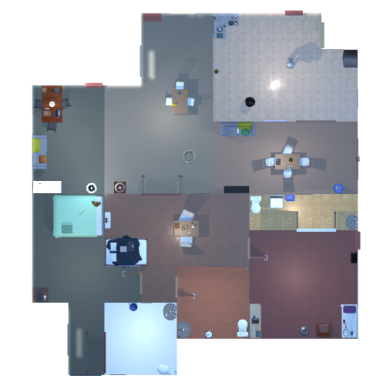

[0] move_to robot countertop|2|0
[1] move_to robot fridge|2|1
[2] move_to robot garbagebag|2|3
[3] move_to robot diningtable|3|0|0
[4] move_to robot chair|3|0|1
[5] move_to robot chair|3|0|2
[6] move_to robot chair|3|0|3
[7] move_to robot chair|3|0|4
[8] move_to robot tvstand|3|1|0
[9] move_to robot garbagecan|3|2
[10] move_to robot sofa|3|3
[11] move_to robot tvstand|4|0|0
[12] move_to robot diningtable|4|1|0
[13] move_to robot chair|4|1|1
[14] move_to robot chair|4|1|2
[15] move_to robot chair|4|1|3
[16] move_to robot dogbed|4|2
[17] move_to robot tvstand|5|0|0
[18] move_to robot diningtable|5|1|0
[19] move_to robot chair|5|1|1
[20] move_to robot chair|5|1|2
[21] move_to robot chair|5|1|3
[22] move_to robot sofa|5|2
[23] move_to robot bed|6|0|0
[24] move_to robot dresser|6|1
[25] move_to robot diningtable|6|2|0
[26] move_to robot chair|6|2|1
[27] move_to robot chair|6|2|2
[28] move_to robot toilet|7|0
[29] move_to robot sink|7|1|0
[30] move_to robot garbagecan|7|2
[31] move_to robot 

>  87


{'washingmachine|11|3'}
State: State<time=0.000, fluents={F(free robot), F(at robot toilet|11|1), F(searched washingmachine|11|3), F(at toiletpaper|surface|11|99 washingmachine|11|3), F(at spraybottle|surface|11|100 toilet|11|1), F(at spraybottle|surface|11|100 washingmachine|11|3), F(at toiletpaper|surface|11|99 toilet|11|1), F(at robot washingmachine|11|3)}, upcoming_effects=>
Robot Pose: (226, 184)


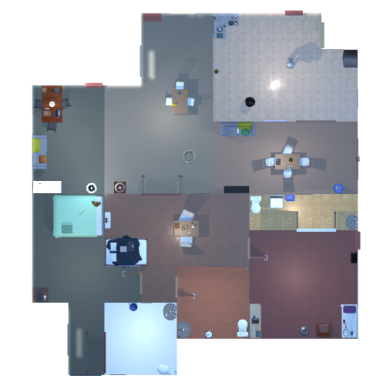

[0] move_to robot countertop|2|0
[1] move_to robot fridge|2|1
[2] move_to robot garbagebag|2|3
[3] move_to robot diningtable|3|0|0
[4] move_to robot chair|3|0|1
[5] move_to robot chair|3|0|2
[6] move_to robot chair|3|0|3
[7] move_to robot chair|3|0|4
[8] move_to robot tvstand|3|1|0
[9] move_to robot garbagecan|3|2
[10] move_to robot sofa|3|3
[11] move_to robot tvstand|4|0|0
[12] move_to robot diningtable|4|1|0
[13] move_to robot chair|4|1|1
[14] move_to robot chair|4|1|2
[15] move_to robot chair|4|1|3
[16] move_to robot dogbed|4|2
[17] move_to robot tvstand|5|0|0
[18] move_to robot diningtable|5|1|0
[19] move_to robot chair|5|1|1
[20] move_to robot chair|5|1|2
[21] move_to robot chair|5|1|3
[22] move_to robot sofa|5|2
[23] move_to robot bed|6|0|0
[24] move_to robot dresser|6|1
[25] move_to robot diningtable|6|2|0
[26] move_to robot chair|6|2|1
[27] move_to robot chair|6|2|2
[28] move_to robot toilet|7|0
[29] move_to robot sink|7|1|0
[30] move_to robot garbagecan|7|2
[31] move_to robot 

>  90


{'washingmachine|11|3'}
State: State<time=5.000, fluents={F(free robot), F(at robot toilet|11|1), F(searched washingmachine|11|3), F(holding robot spraybottle|surface|11|100), F(at toiletpaper|surface|11|99 washingmachine|11|3), F(at spraybottle|surface|11|100 toilet|11|1), F(at spraybottle|surface|11|100 washingmachine|11|3), F(at toiletpaper|surface|11|99 toilet|11|1), F(at robot washingmachine|11|3)}, upcoming_effects=>
Robot Pose: (226, 184)


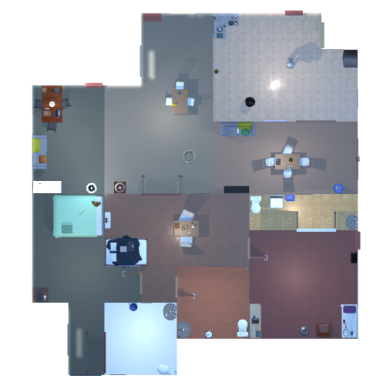

[0] move_to robot countertop|2|0
[1] move_to robot fridge|2|1
[2] move_to robot garbagebag|2|3
[3] move_to robot diningtable|3|0|0
[4] move_to robot chair|3|0|1
[5] move_to robot chair|3|0|2
[6] move_to robot chair|3|0|3
[7] move_to robot chair|3|0|4
[8] move_to robot tvstand|3|1|0
[9] move_to robot garbagecan|3|2
[10] move_to robot sofa|3|3
[11] move_to robot tvstand|4|0|0
[12] move_to robot diningtable|4|1|0
[13] move_to robot chair|4|1|1
[14] move_to robot chair|4|1|2
[15] move_to robot chair|4|1|3
[16] move_to robot dogbed|4|2
[17] move_to robot tvstand|5|0|0
[18] move_to robot diningtable|5|1|0
[19] move_to robot chair|5|1|1
[20] move_to robot chair|5|1|2
[21] move_to robot chair|5|1|3
[22] move_to robot sofa|5|2
[23] move_to robot bed|6|0|0
[24] move_to robot dresser|6|1
[25] move_to robot diningtable|6|2|0
[26] move_to robot chair|6|2|1
[27] move_to robot chair|6|2|2
[28] move_to robot toilet|7|0
[29] move_to robot sink|7|1|0
[30] move_to robot garbagecan|7|2
[31] move_to robot 

>  exit


ValueError: invalid literal for int() with base 10: 'exit'

In [6]:
run_manual_loop()